In [1]:
import arviz as az
import pystan, pickle
import os
# os.environ['STAN_NUM_THREADS'] = "4"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

a = 0.5

# Load Data

In [2]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

dfc = pd.read_csv(url_confirmed)
dfd = pd.read_csv(url_deaths)
dfr = pd.read_csv(url_recovered)

In [3]:
roi = "US_NY"

In [4]:

# dates = dfc.columns[4:].values

# # dfc2 = dfc.loc[dfc['Country/Region']==roi]
# # dfd2 = dfd.loc[dfd['Country/Region']==roi]
# # dfr2 = dfr.loc[dfr['Country/Region']==roi]

# # print(dfc2.columns)

# dfc2 = dfc.loc[dfc['Province/State']==roi]
# dfd2 = dfd.loc[dfd['Province/State']==roi]
# dfr2 = dfr.loc[dfr['Province/State']==roi]




# print(dfc2)


# DF = df = pd.DataFrame(columns=['date',
#                                 'cum_cases','cum_recover','cum_deaths',
#                                'new_cases','new_recover','new_deaths'])


# for i in range(len(dates)):
# #     print(dates[i])
#     DF.loc[i] = pd.Series({'date':dates[i],
#                          'cum_cases':dfc2[dates[i]].values[0],# - (dfr2[dates[i]].values[0] + dfd2[dates[i]].values[0]),
#                          'cum_recover':dfr2[dates[i]].values[0],
#                          'cum_deaths':dfd2[dates[i]].values[0]})

# DF[['new_cases', 'new_deaths', 'new_recover']] = \
#             DF[['cum_cases', 'cum_deaths', 'cum_recover']].diff()

# # print(DF)


[0 '03/04/20' 6 0 0 0 0 0 0]


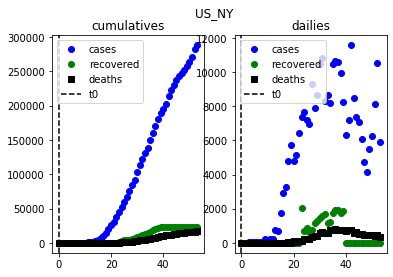

In [5]:
DF = pd.read_csv("../data/covidtimeseries_"+roi+".csv")

# pop = {}
# pop['Italy'] = 60500000
# pop['United Kingdom'] = 64400000
# pop['France'] = 66990000
# pop['Netherlands'] = 17000000

mitigate = {}
mitigate['Italy'] = '03/9/20' #approximate date
mitigate['Netherlands'] = '03/12/20' #approximate date
mitigate['US_NY'] = '03/20/20'
mitigate['UnitedKingdom'] = '3/23/20'


# t0 := where to start time series, index space
t0 = np.where(DF["new_cases"].values>=1)[0][0] - 1 #Stan starts one day back from this 
print(DF.iloc[t0].values)
# tm := start of mitigation, index space
tm = t0 + 10 #np.where(mitigate[roi]==DF['dates2'])[0][0]


#plot the data with important time stamps (t0, tm)
plt.subplot(1,2,1)
plt.title('cumulatives')
plt.plot(DF["cum_cases"][t0:],'bo', label="cases")
plt.plot(DF["cum_recover"][t0:],'go',label="recovered")
plt.plot(DF["cum_deaths"][t0:],'ks',label="deaths")

plt.axvline(t0,color='k', linestyle="dashed", label='t0')
# plt.axvline(tm,color='b', linestyle="dashed", label='mitigate')
plt.legend()


plt.subplot(1,2,2)
plt.title('dailies')
plt.plot(DF["new_cases"][t0:],'bo', label="cases")
plt.plot(DF["new_recover"][t0:],'go',label="recovered")
plt.plot(DF["new_deaths"][t0:],'ks',label="deaths")
plt.axvline(t0,color='k', linestyle="dashed", label='t0')
# plt.axvline(tm,color='b', linestyle="dashed", label='mitigate')
plt.suptitle(roi)
plt.legend()


# print("t0 index assumed to be: day "+str(t0))
# print("t0 date: "+DF['dates2'][t0])
# print("tm index assumed to be: day "+str(tm))
# print("mitigation date: "+DF['dates2'][tm])



In [6]:
DF = DF.fillna(0)


# t0 := where to start time series, index space
t0 = np.where(DF["new_cases"].values>=1)[0][0]

# tm := start of mitigation, index space

stan_data = {}
stan_data['n_scale'] = 1000 #use this instead of population
# stan_data['n_theta'] = 8
stan_data['n_difeq'] = 5
stan_data['n_ostates'] = 3
stan_data['t0'] = t0-1 #to for ODE is day one, index before start of series
stan_data['tm'] = t0 + 10
stan_data['ts'] = np.arange(t0,90+len(DF['dates2']))
# stan_data['y'] = (DF[['new_cases','new_recover','new_deaths']].to_numpy()).astype(int)[t0:,:]
stan_data['n_obs'] = 90+len(DF['dates2']) - t0 




In [7]:
# t0 = 10
# y = DF["new_cases"].to_numpy().astype(int)[t0:]
# plt.plot(y)
# y = DF["new_cases"][t0:]
# plt.plot(y)

In [8]:
from __init__ import extract_samples, make_histograms, make_lineplots, get_timing, plot_data_and_fits

modelname = 'nonlinearmodel'# 'fulllinearmodel'
modelpath = '.'
fitpath = '/Users/aavattikutis/Documents/epidemicmodel/cccruns/fits/fit3/'
samples = extract_samples(fitpath, modelpath, modelname, roi, 1)
# [print(i) for i in samples.keys()]

In [9]:
# [print(i) for i in samples.keys()]

In [10]:
#setup resampler
theta_ = ['f1','f2','sigmar','sigmad','sigmau','q','mbase','mlocation','extra_std','cbase','clocation','n_pop']

# print(np.shape(samples['lambda[1,1]']))

#get the nobs from scanning lambda vector
for i in range(1000,0,-1):
    try:
        x = samples['lambda['+str(i)+',1]']
        break
    except:
        pass
    
nobs = i + 1
print(nobs)

    
clb = np.zeros((nobs))
rlb = np.zeros((nobs))
dlb = np.zeros((nobs))

cm = np.zeros((nobs))
rm = np.zeros((nobs))
dm = np.zeros((nobs))

cub = np.zeros((nobs))
rub = np.zeros((nobs))
dub = np.zeros((nobs))

for i in range(1,nobs):
    c = samples['lambda['+str(i)+',1]']
    r = samples['lambda['+str(i)+',2]']
    d = samples['lambda['+str(i)+',3]']
    
    clb[i] = np.percentile(c,2.5)
    cub[i] = np.percentile(c,97.5)
    cm[i] = np.percentile(c,50)
    
    
    rlb[i] = np.percentile(r,2.5)
    rub[i] = np.percentile(r,97.5) 
    rm[i] = np.percentile(r,50)
    
    dlb[i] = np.percentile(d,2.5)
    dub[i] = np.percentile(d,97.5)
    dm[i] = np.percentile(d,50)



43


(0, 41)

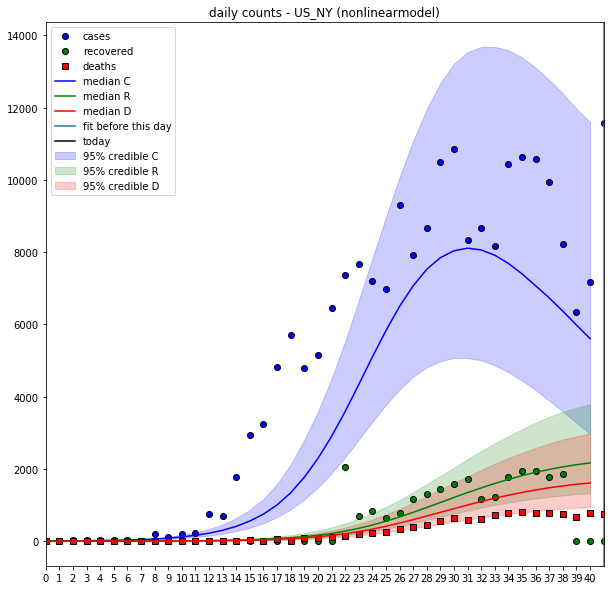

In [11]:

f,ax = plt.subplots(1,1,figsize=(10,10))
plt.title('daily counts - ' +roi+' ('+modelname+')')
t0 = stan_data['t0'] + 1
plt.plot(DF["new_cases"].values[t0:],'bo', markeredgecolor='k',label="cases")
# plt.plot(DF["new_cases"].to_numpy().astype(int)[t0:],'b*', label="cases")
plt.plot(DF["new_recover"].values[t0:],'go',markeredgecolor='k',label="recovered")
plt.plot(DF["new_deaths"].values[t0:],'rs',markeredgecolor='k',label="deaths")

indtfit = int(np.where(DF['dates2']=='04/15/20')[0] - t0)
x = np.arange(0,indtfit)
a=0.2
plt.fill_between(x, clb[:indtfit], cub[:indtfit],color='b',label='95% credible C',alpha=a)
plt.fill_between(x, rlb[:indtfit], rub[:indtfit],color='g',label='95% credible R',alpha=a)
plt.fill_between(x, dlb[:indtfit], dub[:indtfit],color='r',label='95% credible D',alpha=a)

a=1
plt.plot(x, cm[:indtfit],color='b',label='median C',alpha=a)
plt.plot(x, rm[:indtfit],color='g',label='median R',alpha=a)
plt.plot(x, dm[:indtfit],color='r',label='median D',alpha=a)


# plt.fill_between(range(nobs), clb, cub,color='b',label='95% credible C',alpha=a)
# plt.fill_between(range(nobs), rlb, rub,color='g',label='95% credible R',alpha=a)
# plt.fill_between(range(nobs), dlb, dub,color='r',label='95% credible D',alpha=a)


# print(indtfit)
plt.axvline(indtfit,label='fit before this day')
plt.axvline(nobs-90,color='k', label='today')
plt.legend(loc=2)

# x = np.arange(0,nobs,30)+(nobs-90)
plt.xticks(x)
# plt.gca().set_xticklabels(x-(nobs-90))

plt.xlim(0,indtfit)
# plt.ylim((0,1000))

In [12]:
# compile model 
# stanproj = pystan.StanModel(file="fulllinearmodel_predict.stan")#, verbose=True)
# import pickle
# with open("lproj.pkl", "wb") as f:
#     pickle.dump(stanproj, f, protocol=-1)

# stanproj = pickle.load(open('lproj.pkl', 'rb'))

In [13]:
# #setup resampler
# theta_ = ['f1','f2','sigmar','sigmad','sigmau','q','mbase','mlocation','extra_std','cbase','clocation','n_pop']


# nobs = stan_data['n_obs']
# n = 1000
# c = np.zeros((n,nobs))
# r = np.zeros((n,nobs))
# d = np.zeros((n,nobs))

# ind_ = np.arange(len(samples))
# np.random.shuffle(ind_)
# k = -1
# for i in ind_[:n]:
#     k += 1
#     init_ = {}
#     for theta in theta_:
#         try:
#             init_[theta] = samples[theta][i]
#         except:
#             pass

#     predict = stanproj.sampling(data=stan_data,iter=1,init=[init_], chains=1, algorithm = "Fixed_param")

#     c[k,:] += predict.extract()['lambda'][0,:,0]
#     r[k,:] += predict.extract()['lambda'][0,:,1]
#     d[k,:] += predict.extract()['lambda'][0,:,2]


    
# clb = np.zeros((nobs))
# rlb = np.zeros((nobs))
# dlb = np.zeros((nobs))

# cm = np.zeros((nobs))
# rm = np.zeros((nobs))
# dm = np.zeros((nobs))

# cub = np.zeros((nobs))
# rub = np.zeros((nobs))
# dub = np.zeros((nobs))

# for i in range(1,nobs):
#     clb[i] = np.percentile(c[:,i],2.5)
#     cub[i] = np.percentile(c[:,i],97.5)
#     cm[i] = np.percentile(c[:,i],50)
    
#     rlb[i] = np.percentile(r[:,i],2.5)
#     rub[i] = np.percentile(r[:,i],97.5) 
#     rm[i] = np.percentile(r[:,i],50)
    
#     dlb[i] = np.percentile(d[:,i],2.5)
#     dub[i] = np.percentile(d[:,i],97.5)
#     dm[i] = np.percentile(d[:,i],50)
# # print(predict)

# plt.plot(cub)
# plt.plot(rub)


In [14]:
# f,ax = plt.subplots(1,1,figsize=(10,10))
# plt.title('daily counts - ' +roi+' ('+modelname+')')
# t0 = stan_data['t0'] + 1
# plt.plot(DF["new_cases"].values[t0:],'bo', markeredgecolor='k',label="cases")
# # plt.plot(DF["new_cases"].to_numpy().astype(int)[t0:],'b*', label="cases")
# plt.plot(DF["new_recover"].values[t0:],'go',markeredgecolor='k',label="recovered")
# plt.plot(DF["new_deaths"].values[t0:],'rs',markeredgecolor='k',label="deaths")

# indtfit = int(np.where(DF['dates2']=='04/15/20')[0] - t0)
# x = np.arange(0,indtfit)
# a=0.2
# plt.fill_between(x, clb[:indtfit], cub[:indtfit],color='b',label='95% credible C',alpha=a)
# plt.fill_between(x, rlb[:indtfit], rub[:indtfit],color='g',label='95% credible R',alpha=a)
# plt.fill_between(x, dlb[:indtfit], dub[:indtfit],color='r',label='95% credible D',alpha=a)

# a=1
# plt.plot(x, cm[:indtfit],color='b',label='median C',alpha=a)
# plt.plot(x, rm[:indtfit],color='g',label='median R',alpha=a)
# plt.plot(x, dm[:indtfit],color='r',label='median D',alpha=a)


# # plt.fill_between(range(nobs), clb, cub,color='b',label='95% credible C',alpha=a)
# # plt.fill_between(range(nobs), rlb, rub,color='g',label='95% credible R',alpha=a)
# # plt.fill_between(range(nobs), dlb, dub,color='r',label='95% credible D',alpha=a)


# # print(indtfit)
# plt.axvline(indtfit,label='fit before this day')
# plt.axvline(nobs-90,color='k', label='today')
# plt.legend(loc=2)

# # x = np.arange(0,nobs,30)+(nobs-90)
# plt.xticks(x)
# # plt.gca().set_xticklabels(x-(nobs-90))

# plt.xlim(0,indtfit)
# # plt.ylim((0,1000))